# Rt profile multicategorical versus uniform

In [251]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel,  cmdstan_path
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 200 # number of days for incidence data
num_categories = 2

## Parameterize example branching process model with disagregated data

In [252]:
# Build the serial interval w_s
serial_intervals = []

ws_mean_cat = [15.3, 17]
ws_std_cat = [9.3, 5.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(70))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 1

# contact_matrix = contact_matrix
contact_matrix = np.array([[10., 0.], [0., 8]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [1, 1]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_intervals, num_categories, contact_matrix, transmissibility, multipleSI=True)
new_rs = [0.35, 0.05, 0.2, 0.05]          # sequence of R_0 numbers
start_times = [0, 37, 60, 160]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [50, 50] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times, var_contacts=False)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[5.000e+01 5.000e+01]
 [0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00]
 [1.000e+00 0.000e+00]
 [5.000e+00 0.000e+00]
 [1.000e+00 0.000e+00]
 [3.000e+00 0.000e+00]
 [9.000e+00 0.000e+00]
 [5.000e+00 3.000e+00]
 [1.000e+01 2.000e+00]
 [6.000e+00 6.000e+00]
 [1.300e+01 3.000e+00]
 [1.000e+01 4.000e+00]
 [1.200e+01 1.100e+01]
 [1.100e+01 1.400e+01]
 [1.500e+01 1.200e+01]
 [1.200e+01 1.300e+01]
 [1.900e+01 5.000e+00]
 [2.200e+01 1.400e+01]
 [1.500e+01 1.000e+01]
 [2.100e+01 6.000e+00]
 [3.400e+01 1.100e+01]
 [2.800e+01 1.300e+01]
 [3.500e+01 6.000e+00]
 [4.000e+01 6.000e+00]
 [4.900e+01 1.100e+01]
 [3.600e+01 1.400e+01]
 [3.600e+01 1.400e+01]
 [4.500e+01 1.500e+01]
 [4.800e+01 1.800e+01]
 [7.100e+01 1.300e+01]
 [5.100e+01 2.500e+01]
 [8.800e+01 2.500e+01]
 [7.500e+01 1.900e+01]
 [9.600e+01 2.600e+01]
 [1.000e+02 2.000e+01]
 [1.050e+02 2.400e+01]
 [1.350e+02 3.000e+01]
 [1.700e+01 5.000e+00]
 [2.200e+01 3.000e+00]
 [1.100e+01 1.000e+00]
 [3.100e+01 4.000e+00]
 [2.900e+01 2.000e+00]
 [2.200e+01

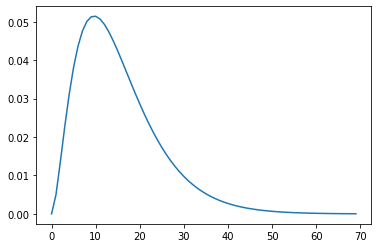

In [253]:
plt.plot(serial_intervals[0, :])
plt.plot(serial_intervals[1, :])

## Plot agreggated local incidence numbers

In [255]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [256]:
# Compute the eigenvalues of the maximum effective contact matrix
eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))

spec_radius = np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix)))

# Compute stability criterion using last change in growth rate
stability_criterion = new_rs[-1] * spec_radius

print(stability_criterion)

0.5


In [257]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

# Correction for overall reproduction number
# Imperfect contacts
eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))
correc_i = np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix)))

In [258]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
L3 = len(np.arange(start_times[2]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': [new_rs[0]*correc_i] * L1 + [new_rs[1]*correc_i] * L2 + [new_rs[2]*correc_i] * L3
})

## Divergence of Means

In [259]:
mean_ratios = []
uni_rate = []
multi_rate = []
shape = []
for t in np.arange(R_t_start, num_timepoints):
    shape.append( a + math.fsum(agg_cases[(t-tau):(t+1)]))
    uni_cat_sum_var = 0
    for k in range(t-tau,t+1):
        if k > len(average_serial_interval):
            vec1 = agg_cases[(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
            vec2 = average_serial_interval[:k] # w_1, ... , w_k
        else:
            vec1 = agg_cases[(k-1)::-1] # I_(k-1), ... , I_0
            vec2 = average_serial_interval[:k] # w_1, ... , w_k
        uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval)
    uni_cat_rate = b + uni_cat_sum_var

    multi_cat_sum_var = 0
    for k_inx, k in enumerate(range(t-tau,t+1)):
        sub_sum_i = 0
        for i in range(num_categories):
            for j in range(num_categories):
                if k > serial_intervals.shape[1]:
                    vec1 = desagg_cases[(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                    vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                else:
                    vec1 = desagg_cases[(k-1)::-1, j] # I_(k-1), ... , I_0
                    vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                sub_sum_j = math.fsum(np.multiply(vec1,vec2))/np.sum(serial_intervals[j,:])
                sub_sum_j *= contact_matrix[i, j] * transmissibility[j]
                sub_sum_i += sub_sum_j
        multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
        # print(multi_cat_sum_var)
    multi_cat_rate = b + (multi_cat_sum_var/spec_radius)

    # print(uni_cat_rate, multi_cat_rate)

    mean_ratios.append(uni_cat_rate / multi_cat_rate)
    uni_rate.append(uni_cat_rate)
    multi_rate.append(multi_cat_rate)

mean_ratio = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': 100 * np.asarray(mean_ratios)
})

In [260]:
# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(uni_rate) == num_timepoints - tau
len(multi_rate) == num_timepoints - tau

mean_uni = np.divide(shape, uni_rate)
mean_multi = np.divide(shape, multi_rate)

uni_post_dist = scipy.stats.gamma(shape,scale = 1/np.array(uni_rate))
uni_post_dist_interval = uni_post_dist.interval(.95)

multi_post_dist = scipy.stats.gamma(shape,scale = 1/np.array(multi_rate))
multi_post_dist_interval = multi_post_dist.interval(.95)

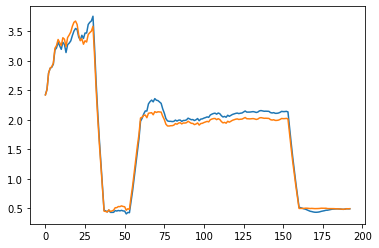

In [261]:
plt.plot(uni_post_dist.mean())
plt.plot(multi_post_dist.mean())

In [262]:
np.array(new_rs) * spec_radius

array([3.5, 0.5, 2. , 0.5])

In [263]:
np.array(new_rs) * 8

array([2.8, 0.4, 1.6, 0.4])

In [264]:
spec_radius

10.0

In [265]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(mean_ratio)    
fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
fig.figure.update_layout(title_text='Multi-categorical versus Standard')

fig.show_figure()

## 1. Contact Tracing + Desaggregated data + Poisson Branching process with multiple categories

In [14]:
approx_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [,] real aSI,
        array [,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI[j, :]) /
                        normalizing_const(aSI[j, :]));
                }
                else {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[j, (S-t+2):]) /
                        normalizing_const(aSI[j, :]));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    real rho_EC; // spectral radius effective contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [n, S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] / rho_EC * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm)); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

approx_multicat_data = {
    'N': num_timepoints,
    'S': serial_intervals.shape[1],
    'n': num_categories,
    'C': contact_matrix,
    'rho_EC': correc_i,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_intervals[:, ::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_30759/3050155256.py:69: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [15]:
posterior = stan.build(
    approx_multicat_model, data=approx_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2800/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   4.407  0.827   2.894    5.904      0.013    0.009    4067.0    2022.0   
R[1]   4.436  0.727   3.191    5.866      0.012    0.009    3634.0    1991.0   
R[2]   4.204  0.640   2.964    5.408      0.011    0.008    3578.0    2131.0   
R[3]   4.153  0.584   3.124    5.289      0.009    0.007    3837.0    2270.0   
R[4]   3.774  0.526   2.804    4.765      0.009    0.006    3622.0    2159.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
R[88]  1.185  0.098   1.004    1.369      0.002    0.001    3719.0    1978.0   
R[89]  1.120  0.094   0.941    1.290      0.001    0.001    3916.0    2015.0   
R[90]  1.105  0.091   0.922    1.264      0.001    0.001    4051.0    1971.0   
R[91]  1.060  0.086   0.898    1.220      0.001    0.001    4699.0    2288.0   
R[92]  1.042  0.089   0.879    1.210      0.001    0.001    4017.0    2322.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
...      ...  
R[88]    1.0  
R[89]    1.0  
R[90]    1.0  
R[91]    1.0  
R[92]    1.0  

[93 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

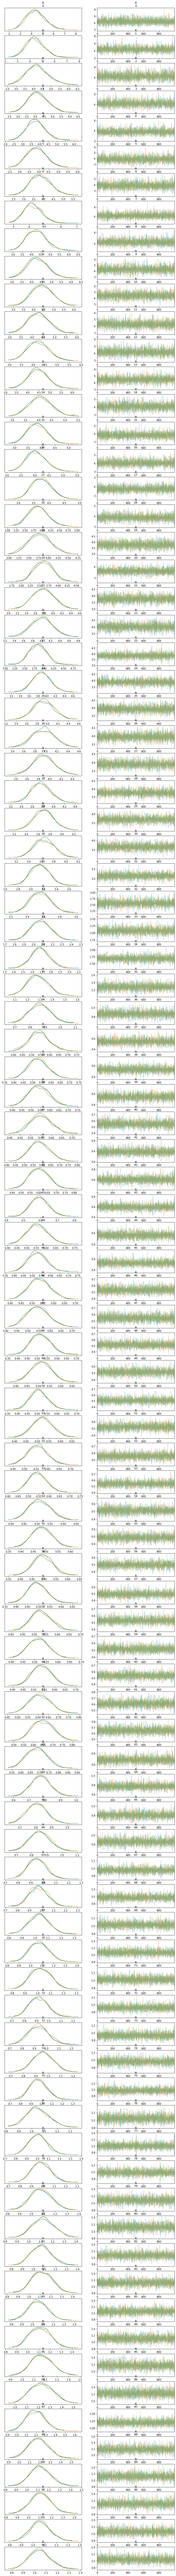

In [16]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [17]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))
approx_multicat_intervals = []


approx_multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2+L3) * [0.95]
})

## 2. Aggregated data + Poisson Branching process

In [18]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(average_serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': average_serial_interval[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_30759/3188657703.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [19]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   3.594  0.662   2.455    4.833      0.010    0.008    4139.0    2161.0   
R[1]   3.568  0.576   2.466    4.615      0.009    0.007    3917.0    2015.0   
R[2]   3.334  0.502   2.363    4.244      0.008    0.006    4081.0    2104.0   
R[3]   3.230  0.455   2.379    4.098      0.008    0.006    3321.0    2176.0   
R[4]   2.848  0.399   2.155    3.630      0.006    0.004    4133.0    1992.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
R[88]  1.031  0.080   0.889    1.186      0.001    0.001    4005.0    2527.0   
R[89]  0.986  0.081   0.842    1.148      0.001    0.001    3976.0    2171.0   
R[90]  0.982  0.081   0.827    1.134      0.001    0.001    3416.0    1841.0   
R[91]  0.955  0.084   0.805    1.115      0.001    0.001    3562.0    1951.0   
R[92]  0.948  0.078   0.808    1.089      0.001    0.001    3341.0    2202.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
...      ...  
R[88]    1.0  
R[89]    1.0  
R[90]    1.0  
R[91]    1.0  
R[92]    1.0  

[93 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

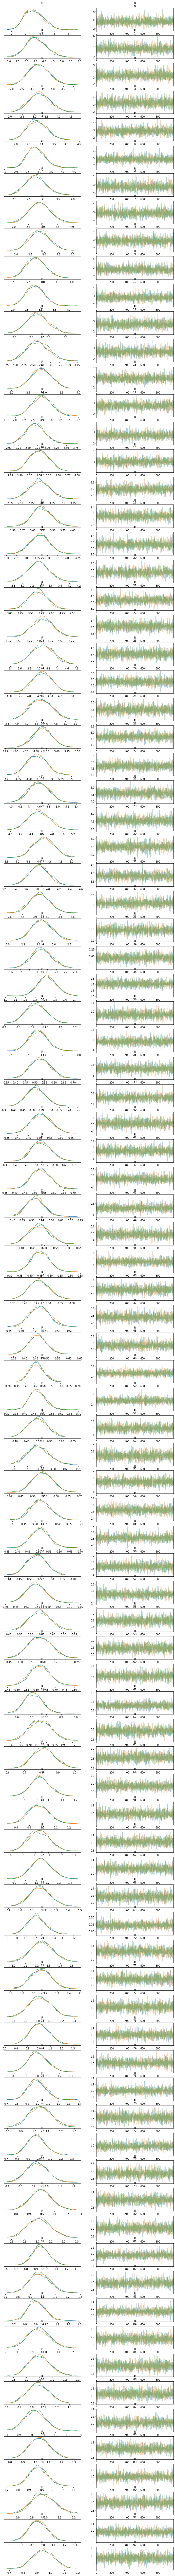

In [20]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [21]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2+L3) * [0.95]
})

## Inference plot using class method results

In [23]:
fig = ReproductionNumberPlot()


fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(approx_multicat_intervals, colour='red', model_type='approximate_contact_tracing multi_categorical')
fig.add_interval_rt(pois_intervals, colour='deepskyblue', model_type='uniform poisson term')
    
fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()